In [2]:
# LT: Exclude DepDelay
# ST: Include DepDelay
# Classification: Predict if arrdelay > 0

# Import Necessary Package here
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix
from sklearn import metrics
from sklearn import preprocessing
import gc

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import  RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier, plot_importance

import matplotlib.pyplot as plt

# Data Import

In [3]:
# Load CSV 
df = pd.read_csv(r"C:\Users\19665\Documents\ORIE-4741-Project\2016_to_2020_flight_feature_eng_w_Dest_10_10.csv")

In [4]:
df = df.drop('Unnamed: 0', axis = 1)
# df = df.drop('Year', axis = 1)
df.columns

Index(['Year', 'Month', 'DayofMonth', 'DepDelay', 'ArrDelay', 'CRSElapsedTime',
       'Distance', 'Severe-Cold_Severity', 'Fog_Severity', 'Hail_Severity',
       'Rain_Severity', 'Snow_Severity', 'Storm_Severity',
       'Other Precipitation_Severity', 'CRSDep_afternoon', 'CRSDep_midnight',
       'CRSDep_morning', 'CRSDep_night', 'CRSArr_afternoon', 'CRSArr_midnight',
       'CRSArr_morning', 'CRSArr_night', 'Q1', 'Q2', 'Q3', 'Q4', 'Mon', 'Tue',
       'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'Airline_9E', 'Airline_AA',
       'Airline_AS', 'Airline_B6', 'Airline_DL', 'Airline_EV', 'Airline_F9',
       'Airline_G4', 'Airline_MQ', 'Airline_NK', 'Airline_OH', 'Airline_OO',
       'Airline_UA', 'Airline_VX', 'Airline_WN', 'Airline_YV', 'Airline_YX',
       'Origin_ATL', 'Origin_CLT', 'Origin_DEN', 'Origin_DFW', 'Origin_LAS',
       'Origin_LAX', 'Origin_MCO', 'Origin_ORD', 'Origin_PHX', 'Origin_SEA',
       'Dest_ATL', 'Dest_CLT', 'Dest_DEN', 'Dest_DFW', 'Dest_LAS', 'Dest_LAX',
       'Dest_M

In [5]:
# Check all columns are in numeric form
df.dtypes[df.dtypes != 'int64'][df.dtypes != 'float64']

Series([], dtype: object)

In [6]:
# Check NA value 
df.isnull().values.any()

False

In [7]:
# Turn Regression into classification problem
df['is_late'] = df['ArrDelay'] > 0
df = df.drop(columns = ['ArrDelay'])

In [8]:
# Inspect all columns
pd.set_option('display.max_columns', None)
df.head() 

,Year,Month,DayofMonth,DepDelay,CRSElapsedTime,Distance,Severe-Cold_Severity,Fog_Severity,Hail_Severity,Rain_Severity,Snow_Severity,Storm_Severity,Other Precipitation_Severity,CRSDep_afternoon,CRSDep_midnight,CRSDep_morning,CRSDep_night,CRSArr_afternoon,CRSArr_midnight,CRSArr_morning,CRSArr_night,Q1,Q2,Q3,Q4,Mon,Tue,Wed,Thu,Fri,Sat,Sun,Airline_9E,Airline_AA,Airline_AS,Airline_B6,Airline_DL,Airline_EV,Airline_F9,Airline_G4,Airline_MQ,Airline_NK,Airline_OH,Airline_OO,Airline_UA,Airline_VX,Airline_WN,Airline_YV,Airline_YX,Origin_ATL,Origin_CLT,Origin_DEN,Origin_DFW,Origin_LAS,Origin_LAX,Origin_MCO,Origin_ORD,Origin_PHX,Origin_SEA,Dest_ATL,Dest_CLT,Dest_DEN,Dest_DFW,Dest_LAS,Dest_LAX,Dest_MCO,Dest_ORD,Dest_PHX,Dest_SEA,is_late
0,2016,1,1,0.0,148.0,868.0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,False
1,2016,1,2,11.0,148.0,868.0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,False
2,2016,1,3,11.0,148.0,868.0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,False
3,2016,1,4,2.0,148.0,868.0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,True
4,2016,1,5,558.0,149.0,868.0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,True


In [9]:
weather_columns = ['Severe-Cold', 'Fog', 'Hail', 'Rain', 'Snow', 'Storm', 'Other Precipitation']
ST_columns = ['DepDelay'] 
df_LT = df[df.columns.difference(ST_columns)]
# df_ST = df

In [10]:
del [[df]]
gc.collect()

18

In [11]:
# Specify X and y
X = df_LT.drop(columns = ['is_late'])
y = pd.DataFrame(df_LT['is_late'])

# X = df_ST.drop(columns = ['is_late'])
# y = pd.DataFrame(df_ST['is_late'])


# Perform train-test-validation split (Train: 0.6, test: 0.2, Val: 0.2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

# X_train, y_train = X[X['Year']<2020], y[X['Year']<2020]
# X_test, y_test = X[X['Year']==2020], y[X['Year']==2020]
                                        

In [12]:
X_val.shape

(393817, 68)

In [13]:
X_test.shape

(393817, 68)

In [14]:
X_train.shape

(1181450, 68)

In [16]:
y_test.head()

,is_late
273899,False
1791745,False
1540464,False
55081,True
1066254,True


In [15]:
def plot_feature_importances(model, feature_names, top_n = None, fig_size = (10,10), title = 'Feature Importance'):
    n_features = len(feature_names)
    importance = model.feature_importances_
    indices = np.argsort(importance)
    plt.figure(figsize=fig_size)
    if top_n:
        plt.barh(range(top_n), importance[indices[-top_n:]], align='center')
        plt.yticks(np.arange(top_n), feature_names[-top_n:])
    else:
        plt.barh(range(n_features), importance[indices], align='center')
        plt.yticks(np.arange(n_features), feature_names)
    plt.xlabel('Feature importance')
    plt.ylabel('Features')
    plt.grid(True)
    plt.title(title)

# Random Forest (LT)
As a start, we will fit a RandomForest Classifier with y = is_late. As the dataset is inbalanced, we would use the weighted avg of F-1 score as our evaluation metrics

### Balanced vs inbalanced Random Forest Model

In [14]:
forest = RandomForestClassifier(class_weight = 'balanced', n_jobs = 7, verbose = 1, max_depth = 5)
forest.fit(X_train, y_train.values.ravel())

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    8.6s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:   21.0s finished


RandomForestClassifier(class_weight='balanced', max_depth=5, n_jobs=7,
                       verbose=1)

In [15]:
# See Train 
pred = forest.predict(X_train)
print(classification_report(y_train.values.ravel(), pred))

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.4s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    1.2s finished


              precision    recall  f1-score   support

       False       0.70      0.57      0.63    748690
        True       0.44      0.58      0.50    432760

    accuracy                           0.57   1181450
   macro avg       0.57      0.57      0.56   1181450
weighted avg       0.60      0.57      0.58   1181450



In [16]:
# See Test 
pred = forest.predict(X_test)
print(classification_report(y_test.values.ravel(), pred))

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.3s finished


              precision    recall  f1-score   support

       False       0.70      0.57      0.63    249084
        True       0.44      0.58      0.50    144733

    accuracy                           0.57    393817
   macro avg       0.57      0.57      0.56    393817
weighted avg       0.60      0.57      0.58    393817



In [17]:
forest = RandomForestClassifier(class_weight = None, n_jobs = 7, verbose = 1, max_depth = 5)
forest.fit(X_train, y_train.values.ravel())

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    8.5s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:   20.8s finished


RandomForestClassifier(max_depth=5, n_jobs=7, verbose=1)

In [18]:
# See Train 
pred = forest.predict(X_train)
print(classification_report(y_train.values.ravel(), pred))

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.4s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    1.1s finished


              precision    recall  f1-score   support

       False       0.64      1.00      0.78    748690
        True       0.80      0.01      0.02    432760

    accuracy                           0.64   1181450
   macro avg       0.72      0.50      0.40   1181450
weighted avg       0.70      0.64      0.50   1181450



In [19]:
# See Test 
pred = forest.predict(X_test)
print(classification_report(y_test.values.ravel(), pred))

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.3s finished


              precision    recall  f1-score   support

       False       0.63      1.00      0.78    249084
        True       0.79      0.01      0.02    144733

    accuracy                           0.64    393817
   macro avg       0.71      0.50      0.40    393817
weighted avg       0.69      0.64      0.50    393817



### Conclusion
Balanced models seems to yield better testing performance

### Dummy Majority Classifier Result

In [20]:
# See dummy majority classfier
pred = np.zeros(y_test.values.shape[0])
print(classification_report(y_test.values.ravel(), pred))

C:\Users\19665\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\19665\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       False       0.63      1.00      0.77    248765
        True       0.00      0.00      0.00    145052

    accuracy                           0.63    393817
   macro avg       0.32      0.50      0.39    393817
weighted avg       0.40      0.63      0.49    393817



C:\Users\19665\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Feature Scaling and Normalization
Although most of our data features are one-hot generated, features like year and distance are order-of-magitude different from 1 and 0. We would like to see if normalizing all features to the same scale could help mitigate this disrepency

In [27]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
# Use same scaler obtained from training sample because test data are supposed to be completely unknown
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

In [28]:
forest = RandomForestClassifier(class_weight = 'balanced', n_jobs = 7, verbose = 1, max_depth = 5)
forest.fit(X_train_scaled, y_train.values.ravel())

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    8.3s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:   20.7s finished


RandomForestClassifier(class_weight='balanced', max_depth=5, n_jobs=7,
                       verbose=1)

In [30]:
# See Train 
pred = forest.predict(X_train_scaled)
print(classification_report(y_train.values.ravel(), pred))

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.4s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    1.2s finished


              precision    recall  f1-score   support

       False       0.70      0.57      0.63    748881
        True       0.44      0.58      0.50    432569

    accuracy                           0.57   1181450
   macro avg       0.57      0.57      0.56   1181450
weighted avg       0.60      0.57      0.58   1181450



In [31]:
# See Test 
pred = forest.predict(X_test_scaled)
print(classification_report(y_test.values.ravel(), pred))

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.3s finished


              precision    recall  f1-score   support

       False       0.70      0.57      0.63    248765
        True       0.44      0.57      0.50    145052

    accuracy                           0.57    393817
   macro avg       0.57      0.57      0.56    393817
weighted avg       0.60      0.57      0.58    393817



### Conclusion
We are able to confirm that normalization is **not** helpful for random forest classifier

## Hyperparameter Tuning
Since more tree does not typicaly leads to overfit, we decided to tune the other parameters, and then use more trees in the final model. We decided to optimize the following hyperparameters:
1. Criterion
2. Max depth of each tree
3. Fraction of Samples used to generate each tree

There exits other hyperparameters that we are not optimizing, because we believe they do not carry a large impact on the performance of the model

In [21]:
parameters =  [{'criterion': ['gini','entropy'], 'max_depth': [5, 10, 50, 100], 'max_samples' : [0.3, 0.5, 0.8]}]
clf = GridSearchCV(RandomForestClassifier(class_weight = 'balanced'), parameters, scoring='f1_weighted', n_jobs = 7, verbose = 3, cv = 3)
clf.fit(X_train, y_train.values.ravel())

Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=7,
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_depth': [5, 10, 50, 100],
                          'max_samples': [0.3, 0.5, 0.8]}],
             scoring='f1_weighted', verbose=3)

In [22]:
print(clf.best_params_)

{'criterion': 'entropy', 'max_depth': 50, 'max_samples': 0.5}


### Result


## Final Model
Our final RandomForest model has the following parameters:
1. balanced data
2. unnormalized features


In [17]:
forest_final = RandomForestClassifier(criterion = 'entropy', n_jobs = 7, max_depth = 50, max_samples = 0.5, n_estimators = 100, verbose = 1)
forest_final.fit(X_train, y_train.values.ravel())


[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   18.2s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:   45.8s finished


RandomForestClassifier(criterion='entropy', max_depth=50, max_samples=0.5,
                       n_jobs=7, verbose=1)

In [18]:
# See Train 
pred = forest_final.predict(X_train)
print(classification_report(y_train.values.ravel(), pred))

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    4.9s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:   12.8s finished


              precision    recall  f1-score   support

       False       0.93      0.99      0.96    748772
        True       0.98      0.88      0.93    432678

    accuracy                           0.95   1181450
   macro avg       0.96      0.93      0.94   1181450
weighted avg       0.95      0.95      0.95   1181450



In [19]:
# See Test 
pred = forest_final.predict(X_test)
print(classification_report(y_test.values.ravel(), pred))

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    1.6s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    4.2s finished


              precision    recall  f1-score   support

       False       0.70      0.84      0.76    249101
        True       0.58      0.38      0.46    144716

    accuracy                           0.67    393817
   macro avg       0.64      0.61      0.61    393817
weighted avg       0.65      0.67      0.65    393817



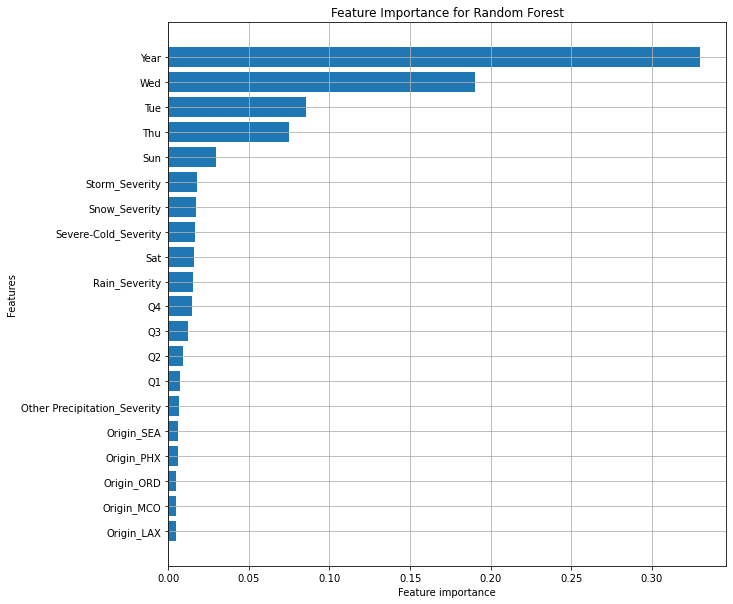

In [52]:
feature_names = X_train.columns.values
plot_feature_importances(forest_final, feature_names, top_n=20, title = 'Feature Importance for Random Forest')

## Fairness Assesment (Equality of opportunity)

In [27]:
curr_airline_res = []
other_airline_res = []
names = []
for col_name in X_test.columns:
    if 'Airline_' in col_name:
        X_air = X_test.loc[(X_test[col_name] == 1) & (y_test['is_late'] == False)]
        y_air = y_test.loc[(X_test[col_name] == 1)& (y_test['is_late']== False)]
        
        X_other = X_test.loc[(X_test[col_name] == 0) & (y_test['is_late']== False)]
        y_other = y_test.loc[(X_test[col_name] == 0)& (y_test['is_late']== False)]
        
        pred_air = forest_final.predict(X_air)
        pred_others = forest_final.predict(X_other)
        
        names.append(col_name)
        curr_airline_res.append(1-np.mean(pred_air))
        other_airline_res.append(1-np.mean(pred_others))

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.9s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.2s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.5s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_job

In [28]:
curr_airline_res

[1.0,
 0.8081366452097805,
 0.8110385756676558,
 0.8711018711018711,
 0.901658520282408,
 0.9150943396226415,
 0.8161605764282038,
 0.8571428571428572,
 0.8207885304659498,
 0.840644127076654,
 0.7728937728937729,
 0.8245055090933227,
 0.891394201989681,
 0.6666666666666667,
 0.7722114498235799,
 0.6503067484662577,
 0.8777372262773723]

In [29]:
other_airline_res

[0.8355527007768121,
 0.8491327051197407,
 0.8373354689538474,
 0.8354878931703,
 0.8198303408588311,
 0.835488912728164,
 0.8363396355676607,
 0.8355560551438412,
 0.8355732210174341,
 0.8352557811510896,
 0.8356902898754803,
 0.8359012783150086,
 0.8263994019250538,
 0.8366374834859828,
 0.8447128771101167,
 0.8356779599739694,
 0.835370254631963]

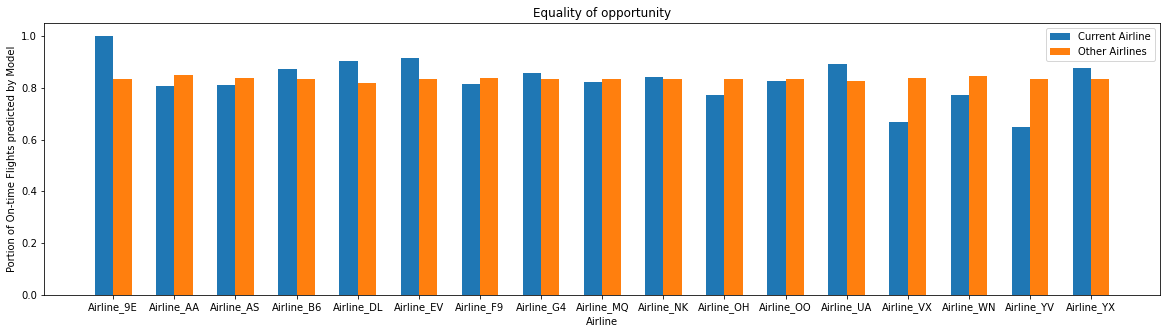

In [35]:
N = len(names)
ind = np.arange(N)
plt.figure(figsize=(20,5))
width = 0.3 
plt.bar(ind, curr_airline_res , width, label='Current Airline')
plt.bar(ind + width, other_airline_res, width, label='Other Airlines')
plt.xlabel('Airline')
plt.ylabel('Portion of On-time Flights predicted by Model')
plt.title('Equality of opportunity')
plt.xticks(ind + width / 2, names)
plt.legend(loc='best')
plt.show()

In [37]:
np.mean(df_LT['Airline_YV'])

0.000808497758348552

In [38]:
np.mean(df_LT['Airline_VX'])

0.007737100093241325

In [39]:
np.mean(df_LT['Airline_WN'])

0.13788340162227716

In [40]:
np.mean(df_LT['Airline_9E'])

2.539251753607261e-05